In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install torchviz
!pip install torchview
!pip install torchsummary

  Preparing metadata (setup.py) ... - done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4131 sha256=1e96105841c9e06c5188125fa42f7955512ed67934c5568e7070e7fc05ce6cc3
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [3]:
import torch
torch.manual_seed(42)

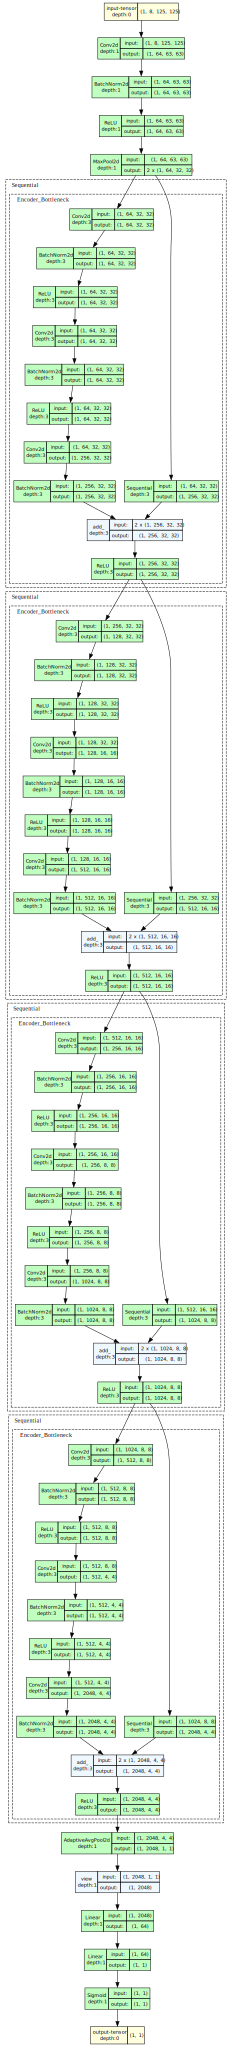

In [4]:

from functools import partial
from typing import Any, Callable, List, Optional, Type, Union

import torch
import torch.nn as nn
from torch import Tensor

from torchsummary import summary

'''
Modified from https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py
'''

def enc_conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )


def enc_conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class Encoder_Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = enc_conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = enc_conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = enc_conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Encoder(nn.Module):
    def __init__(
        self,
        block,
        layers: List[int],
        num_classes: int = 1000,
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        replace_stride_with_dilation: Optional[List[bool]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
        return_indices = False,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError(
                "replace_stride_with_dilation should be None "
                f"or a 3-element tuple, got {replace_stride_with_dilation}"
            )
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(8, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        # self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, 64)
        self.fc1 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()
        self.return_indices = return_indices
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, return_indices=True)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck) and m.bn3.weight is not None:
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock) and m.bn2.weight is not None:
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(
        self,
        block,
        planes: int,
        blocks: int,
        stride: int = 1,
        dilate: bool = False,
    ) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                enc_conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes, planes, stride, downsample, self.groups, self.base_width, previous_dilation, norm_layer
            )
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer,
                )
            )

        return nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        if self.return_indices:
            x, indices = self.maxpool(x)
        else:
            x, _ = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)

        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self.fc1(x)
        x = self.sigmoid(x)
#         if self.return_indices:
#             return x, indices
#         else:
#             return x, []
        return x


    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)

# if __name__ == "__main__":
    # image size: [64, 3, 224, 224]
    # feature size: [64, 2048]
encoder = Encoder(Encoder_Bottleneck, [1, 1, 1, 1], return_indices=False)
# resnet101 = ResNet(Bottleneck, [3, 4, 23, 3])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)

# summary(resnet50, (3, 224, 224))
import torchvision
from torchview import draw_graph
from torchviz import make_dot

model_graph = draw_graph(encoder, input_size=(1,8,125,125), expand_nested=True)
model_graph.visual_graph
    
    # test_input = torch.rand(2, 3, 224, 224).to(device)
    # out, indices = resnet50(test_input)
    # print(out.shape, len(indices))


In [5]:
inp = torch.rand((1,8,125,125)).to('cuda')
op = encoder(inp)
print(op.shape)

torch.Size([1, 1])


In [6]:
# model_graph = draw_graph(encoder, input_size=(1, 8, 125, 125), expand_nested=True)
# model_graph.visual_graph

In [7]:
inp.shape

torch.Size([1, 8, 125, 125])

In [8]:
# inp = inp.permute(0,2,3,1).cpu().numpy()

In [9]:
# import matplotlib.pyplot as plt
# # inp = inp.permute(0,1,2,3).cpu().numpy()
# for i in range(8):
#     plt.imshow(inp[0][:,:,i])
#     plt.show()

In [10]:
# import matplotlib.pyplot as plt
# op = op.permute(0,2,3,1).cpu().detach().numpy()
# for i in range(8):
#     plt.imshow(op[0][:,:,i])
#     plt.show()

In [11]:
import h5py
import numpy as np
with h5py.File('/kaggle/input/autoencoders-labelled/Dataset_Specific_labelled.h5', 'r') as file:
    # List all the groups in the file
    print("Groups in the HDF5 file:")
    for group in file:
        print(group)

    # Get information about a specific dataset
    dataset = file['jet']
    print("Dataset shape:", dataset.shape)
    print("Dataset dtype:", dataset.dtype)
    
    dataset = file['Y']
    print("Dataset shape:", dataset.shape)
    print("Dataset dtype:", dataset.dtype)


    # Explore attributes of the dataset
    print("Dataset attributes:")
    for attr_name, attr_value in dataset.attrs.items():
        print(f"{attr_name}: {attr_value}")

    X = np.array(file['jet'][:])
    Y = np.array(file['Y'][:])

Groups in the HDF5 file:
Y
jet
Dataset shape: (10000, 125, 125, 8)
Dataset dtype: float32
Dataset shape: (10000, 1)
Dataset dtype: float32
Dataset attributes:


In [12]:
count = np.sum(Y == 0)
count

5122

In [13]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

class Custom_Dataset(Dataset):
    def __init__(self, x, y, transform):
        self.x = x
        self.y = y
        self.transform = transform
        
    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_1 = self.x[idx]
        label = self.y[idx]
        
        if self.transform:
            img_1 = self.transform(img_1)
            
        sample = {'img' : img_1, 'label' : label}
        
        return sample
    
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

dataset = Custom_Dataset(X, Y, transform = transform)
sample = dataset.__getitem__(9500)
print((sample['img']).shape)
print(sample['label'])

torch.Size([8, 125, 125])
[0.]


In [14]:
# np.min(X_train)

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import h5py
from torch import Tensor
from typing import Type
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision
from torchview import draw_graph
from torchviz import make_dot
import warnings
warnings.filterwarnings("ignore")
from torchmetrics import Accuracy
import copy
import torch.optim as optim
import tqdm
from tqdm import tqdm
from torchmetrics import Accuracy
from torch.utils.data import TensorDataset,random_split,SubsetRandomSampler, ConcatDataset
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from PIL import Image


def model_train(fold, model, epochs, train_dataloader, test_dataloader):
    
    # --------------------Loss function and optimizer--------------------
    criterion = nn.BCELoss()  # Binary Cross Entropy
    optimizer = optim.AdamW(model.parameters(), lr=1.5e-5, weight_decay = 0.5)
    # -------------------------------------------------------------------

    best_acc = -np.inf  # Init to negative infinity
    best_weights = None
    accuracy = Accuracy(task = 'binary').to(DEVICE)
 
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        train_pred = []
        val_pred = []
        train_accuracy = []
        val_accuracy = []
        
        # --------------------Training Loop--------------------
        model.train()
        for batch in tqdm(train_dataloader):
            images, labels = batch['img'], batch['label']
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_pred.append(loss.item())

            # Calculate training accuracy
            train_acc = accuracy(outputs, labels)
            train_accuracy.append(train_acc.item())

        train_loss = np.mean(train_pred)
        train_accuracies.append(np.mean(train_accuracy))
        # -------------------------------------------------------
        # -------------------------------------------------------
        
        # --------------------Validation Loop--------------------
        model.eval()
        with torch.no_grad():
            for val_batch in tqdm(test_dataloader):
                val_images, val_labels = val_batch['img'], val_batch['label']
                val_images = val_images.to(DEVICE)
                val_labels = val_labels.to(DEVICE)

                val_outputs = model(val_images)
                val_loss = criterion(val_outputs, val_labels)
                val_pred.append(val_loss.item())

                # Calculate validation accuracy
                val_acc = accuracy(val_outputs, val_labels)
                val_accuracy.append(val_acc.item())

        val_loss = np.mean(val_pred)
        val_accuracies.append(np.mean(val_accuracy))
        # -------------------------------------------------------
        # -------------------------------------------------------
        
        # Print and store losses and accuracies
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {np.mean(train_accuracies):.4f}, Valid Loss: {val_loss:.4f}, Valid Accuracy: {np.mean(val_accuracies):.4f}')
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Save best model
        if max(train_accuracies) > best_acc:
            best_acc = max(train_accuracies)
            best_weights = copy.deepcopy(model.state_dict())
    
    # Save the best model
    torch.save(best_weights, f'./best_model_{fold}.pth')

    # Plot training and validation losses
    return train_losses, val_losses, train_accuracies, val_accuracies

In [16]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
training_loss = []
validation_loss = []
# Create data loaders
DEVICE = torch.device('cuda')
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
classifier = encoder
NUM_GPU = torch.cuda.device_count()
if NUM_GPU > 1:
    classifier = nn.DataParallel(classifier)
classifier = classifier.to(DEVICE)

train_losses, val_losses, train_accuracies, val_accuracies = model_train(1,classifier, 5, train_dataloader, val_dataloader)

100%|██████████| 32/32 [00:01<00:00, 25.88it/s]


Epoch 1/5, Train Loss: 0.6554, Train Accuracy: 0.6266, Valid Loss: 0.6225, Valid Accuracy: 0.6851


100%|██████████| 32/32 [00:01<00:00, 27.00it/s]


Epoch 2/5, Train Loss: 0.5785, Train Accuracy: 0.6725, Valid Loss: 0.5642, Valid Accuracy: 0.7126


100%|██████████| 32/32 [00:01<00:00, 26.92it/s]


Epoch 3/5, Train Loss: 0.4996, Train Accuracy: 0.7091, Valid Loss: 0.5138, Valid Accuracy: 0.7316


100%|██████████| 32/32 [00:01<00:00, 26.48it/s]


Epoch 4/5, Train Loss: 0.4011, Train Accuracy: 0.7418, Valid Loss: 0.4763, Valid Accuracy: 0.7506


100%|██████████| 32/32 [00:01<00:00, 26.79it/s]


Epoch 5/5, Train Loss: 0.2874, Train Accuracy: 0.7735, Valid Loss: 0.4583, Valid Accuracy: 0.7589


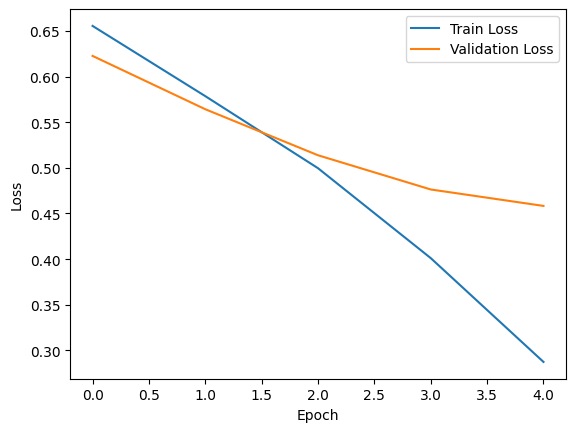

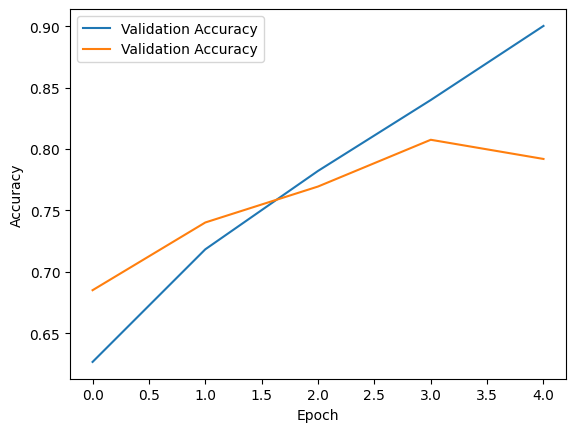

In [17]:
import matplotlib.pyplot as plt

# Plot losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(train_accuracies, label='Validation Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
